In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def importar_dados(ticker, inicio, fim):
    dados = yf.download(ticker, start=inicio, end=fim)
    dados = dados[['Open', 'High', 'Low', 'Close', 'Volume']]
    dados.dropna(inplace=True)
    return dados

In [18]:
def estrategia_media_movel(dados, rapida=9, lenta=21):
    dados = dados.copy()
    dados['MM_Rapida'] = dados['Close'].rolling(window=rapida).mean()
    dados['MM_Lenta'] = dados['Close'].rolling(window=lenta).mean()

    # Criando coluna 'Sinal' apenas onde ambas as MMs existem (sem NaN)
    dados['Sinal'] = 0  # inicializa
    condicao_valida = dados['MM_Rapida'].notna() & dados['MM_Lenta'].notna()
    dados.loc[condicao_valida, 'Sinal'] = np.where(
        dados.loc[condicao_valida, 'MM_Rapida'] > dados.loc[condicao_valida, 'MM_Lenta'],
        1,
        0
    )

    dados['Posição'] = dados['Sinal'].diff().fillna(0)

    return dados


In [4]:
def backtest(dados, capital_inicial=10000):
    entradas = dados[dados['Posição'] == 1]
    saidas = dados[dados['Posição'] == -1]

    entradas = entradas[:len(saidas)].reset_index()
    saidas = saidas.reset_index()

    resultados = pd.DataFrame()
    resultados['Data_Entrada'] = entradas['Date']
    resultados['Data_Saída'] = saidas['Date']
    resultados['Entrada'] = entradas['Close']
    resultados['Saída'] = saidas['Close']
    resultados['Retorno (%)'] = (resultados['Saída'] - resultados['Entrada']) / resultados['Entrada'] * 100

    # Simulação de capital
    capital = [capital_inicial]
    for r in resultados['Retorno (%)']:
        capital.append(capital[-1] * (1 + r / 100))
    capital = capital[1:]
    resultados['Capital'] = capital

    # Drawdown
    resultados['Pico'] = resultados['Capital'].cummax()
    resultados['Drawdown (%)'] = (resultados['Capital'] - resultados['Pico']) / resultados['Pico'] * 100

    return resultados

In [5]:
def mostrar_resultados(resultados):
    lucro_total = resultados['Retorno (%)'].sum()
    taxa_acerto = (resultados['Retorno (%)'] > 0).mean() * 100
    drawdown_max = resultados['Drawdown (%)'].min()
    capital_final = resultados['Capital'].iloc[-1]

    print(f"💼 Capital final: R$ {capital_final:.2f}")
    print(f"📈 Lucro total: {lucro_total:.2f}%")
    print(f"✅ Taxa de acerto: {taxa_acerto:.2f}%")
    print(f"📉 Drawdown máximo: {drawdown_max:.2f}%")

    # Gráfico
    plt.figure(figsize=(12, 5))
    plt.plot(resultados['Data_Saída'], resultados['Capital'], label='Capital')
    plt.title('Evolução do Capital')
    plt.xlabel('Data')
    plt.ylabel('R$')
    plt.grid()
    plt.legend()
    plt.show()


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


💼 Capital final: R$ 14937.18
📈 Lucro total: 54.44%
✅ Taxa de acerto: 46.15%
📉 Drawdown máximo: -25.65%


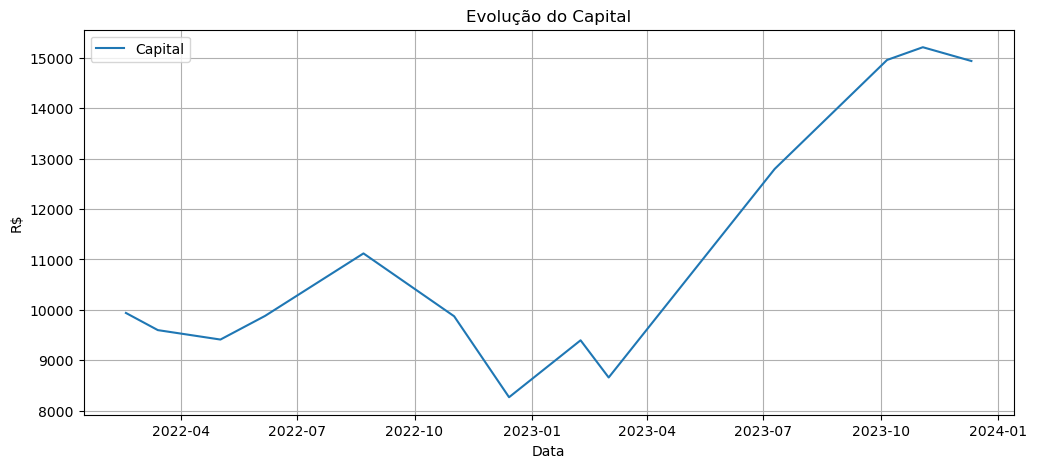

In [6]:
dados = importar_dados('PETR4.SA', '2022-01-01', '2023-12-31')
dados = estrategia_media_movel(dados)
resultado = backtest(dados)
mostrar_resultados(resultado)

In [9]:
def backtest_com_stop_take(dados, stop_loss=3.0, take_profit=5.0, capital_inicial=10000):
    entradas = dados[dados['Posição'] == 1].copy().reset_index()
    saidas = dados[dados['Posição'] == -1].copy().reset_index()

    entradas = entradas[:len(saidas)]  # Garante pares válidos

    resultados = []

    for i in range(len(entradas)):
        data_entrada = entradas.loc[i, 'Date']
        data_saida = saidas.loc[i, 'Date']
        preco_entrada = entradas.loc[i, 'Close']

        # Filtra as linhas entre entrada e saída pela coluna 'Date'
        janela = dados[(dados['Date'] > data_entrada) & (dados['Date'] <= data_saida)].copy()

        saida_efetiva = preco_entrada
        data_efetiva = data_saida
        tipo_saida = 'Saída normal'

        for _, row in janela.iterrows():
            preco_max = row['High']
            preco_min = row['Low']
            data = row['Date']

            if preco_max >= preco_entrada * (1 + take_profit / 100):
                saida_efetiva = preco_entrada * (1 + take_profit / 100)
                data_efetiva = data
                tipo_saida = 'Take Profit'
                break
            elif preco_min <= preco_entrada * (1 - stop_loss / 100):
                saida_efetiva = preco_entrada * (1 - stop_loss / 100)
                data_efetiva = data
                tipo_saida = 'Stop Loss'
                break

        retorno = (saida_efetiva - preco_entrada) / preco_entrada * 100

        resultados.append({
            'Data_Entrada': data_entrada,
            'Data_Saída': data_efetiva,
            'Entrada': preco_entrada,
            'Saída': saida_efetiva,
            'Tipo': tipo_saida,
            'Retorno (%)': retorno,
        })

    df_resultados = pd.DataFrame(resultados)

    # Simulação de capital
    capital = [capital_inicial]
    for r in df_resultados['Retorno (%)']:
        capital.append(capital[-1] * (1 + r / 100))
    df_resultados['Capital'] = capital[1:]

    # Drawdown
    df_resultados['Pico'] = df_resultados['Capital'].cummax()
    df_resultados['Drawdown (%)'] = (df_resultados['Capital'] - df_resultados['Pico']) / df_resultados['Pico'] * 100

    return df_resultados


In [27]:
dados = importar_dados('PETR4.SA', '2022-01-01', '2023-12-31')
dados = dados.reset_index()
dados = estrategia_media_movel(dados)
# dados = dados.dropna(subset=['MM_Rapida', 'MM_Lenta'])  # importante!
resultado = backtest_com_stop_take(dados, stop_loss=3, take_profit=5)
mostrar_resultados(resultado)


[*********************100%***********************]  1 of 1 completed


ValueError: Can only compare identically-labeled Series objects

In [26]:
dados = importar_dados('PETR4.SA', '2022-01-01', '2023-12-31')
dados = dados.reset_index()
dados = estrategia_media_movel(dados)
dados.tail()

[*********************100%***********************]  1 of 1 completed


Price,Date,Open,High,Low,Close,Volume,MM_Rapida,MM_Lenta,Sinal,Posição
Ticker,,PETR4.SA,PETR4.SA,PETR4.SA,PETR4.SA,PETR4.SA,,,,
493,2023-12-21,30.357249,30.365529,29.860540,30.125452,30511900,29.304964,29.076450,1,0.0
494,2023-12-22,30.216520,30.464874,30.108898,30.415205,31234700,29.523885,29.138342,1,0.0
495,2023-12-26,30.514546,30.936749,30.489712,30.903637,23466800,29.822831,29.219550,1,0.0
496,2023-12-27,30.895356,30.986420,30.738066,30.928471,19588500,30.079464,29.309826,1,0.0
497,2023-12-28,30.820844,30.928466,30.663554,30.829124,21421900,30.256072,29.374477,1,0.0


In [32]:
import yfinance as yf
import pandas as pd
import numpy as np

def importar_dados(ticker, inicio, fim):
    df = yf.download(ticker, start=inicio, end=fim)
    df = df[['Open', 'High', 'Low', 'Close', 'Volume']]
    df = df.dropna()
    df = df.reset_index()
    return df

def estrategia_media_movel(dados, rapida=9, lenta=21):
    dados = dados.copy()
    dados['MM_Rapida'] = dados['Close'].rolling(window=rapida).mean()
    dados['MM_Lenta'] = dados['Close'].rolling(window=lenta).mean()
    dados = dados.dropna()

    dados['Sinal'] = np.where(
        dados['MM_Rapida'].values > dados['MM_Lenta'].values,
        1,
        0
    )
    dados['Posição'] = pd.Series(dados['Sinal']).diff().fillna(0)
    return dados

def backtest_com_stop_take(dados, stop_loss=3.0, take_profit=5.0, capital_inicial=10000):
    entradas = dados[dados['Posição'] == 1].copy().reset_index()
    saidas = dados[dados['Posição'] == -1].copy().reset_index()

    entradas = entradas[:len(saidas)]

    resultados = []

    for i in range(len(entradas)):
        data_entrada = entradas.loc[i, 'Date']
        data_saida = saidas.loc[i, 'Date']
        preco_entrada = entradas.loc[i, 'Close']

        janela = dados[(dados['Date'] > data_entrada) & (dados['Date'] <= data_saida)].copy()

        saida_efetiva = preco_entrada
        data_efetiva = data_saida
        tipo_saida = 'Saída normal'

        for _, row in janela.iterrows():
            preco_max = row['High']
            preco_min = row['Low']
            data = row['Date']

            if preco_max >= preco_entrada * (1 + take_profit / 100):
                saida_efetiva = preco_entrada * (1 + take_profit / 100)
                data_efetiva = data
                tipo_saida = 'Take Profit'
                break
            elif preco_min <= preco_entrada * (1 - stop_loss / 100):
                saida_efetiva = preco_entrada * (1 - stop_loss / 100)
                data_efetiva = data
                tipo_saida = 'Stop Loss'
                break

        retorno = (saida_efetiva - preco_entrada) / preco_entrada * 100

        resultados.append({
            'Data_Entrada': data_entrada,
            'Data_Saída': data_efetiva,
            'Entrada': preco_entrada,
            'Saída': saida_efetiva,
            'Tipo': tipo_saida,
            'Retorno (%)': retorno,
        })

    df_resultados = pd.DataFrame(resultados)

    capital = [capital_inicial]
    for r in df_resultados['Retorno (%)']:
        capital.append(capital[-1] * (1 + r / 100))
    df_resultados['Capital'] = capital[1:]

    df_resultados['Pico'] = df_resultados['Capital'].cummax()
    df_resultados['Drawdown (%)'] = (df_resultados['Capital'] - df_resultados['Pico']) / df_resultados['Pico'] * 100

    return df_resultados

def mostrar_resultados(df):
    print(df[['Data_Entrada', 'Data_Saída', 'Entrada', 'Saída', 'Tipo', 'Retorno (%)']])
    print("\nRetorno Total: {:.2f}%".format((df['Capital'].iloc[-1] / df['Capital'].iloc[0] - 1) * 100))
    print("Maior Drawdown: {:.2f}%".format(df['Drawdown (%)'].min()))


In [33]:
dados = importar_dados('PETR4.SA', '2022-01-01', '2023-12-31')
dados = estrategia_media_movel(dados)
# dados = dados.dropna(subset=['MM_Rapida', 'MM_Lenta'])  # Agora vai funcionar
resultado = backtest_com_stop_take(dados, stop_loss=3, take_profit=5)
mostrar_resultados(resultado)

[*********************100%***********************]  1 of 1 completed


ValueError: Can only compare identically-labeled Series objects